In [1]:
# requires seaborn, pandas, tqdm

In [2]:
import uuid
from datetime import datetime
import logging
from tqdm import tqdm

import seaborn as sns
import pandas as pd
import dns.message
import dns.query
import dns.flags
from dns.rdatatype import SOA, TXT, RRSIG, A, AAAA
from dns.rdataclass import IN

logging.basicConfig(level=logging.ERROR, force=True)

sns.set(font_scale=2)
sns.set_style('whitegrid')

def query(qname, rdtype) -> dns.message.Message:
    q = dns.message.make_query(
        qname=qname, rdtype=rdtype, want_dnssec=False, use_edns=0,
    )
    q.flags |= dns.flags.AD
    logging.debug(q.to_text())
    start = datetime.now()
    try:
        r = dns.query.tcp(q, where='127.0.0.1', port=5302, timeout=1)  # local recursor
    except dns.exception.Timeout:
        return None, None
    return r, (datetime.now() - start).total_seconds()

In [3]:
def random_query(algorithm):
    qname = dns.name.from_text(f"{str(uuid.uuid4())}.{algorithm}.example.")
    rdtype = TXT
    r, query_time = query(qname, rdtype)
    if r is not None:
        assert dns.flags.AD in r.flags
        assert len(r.get_rrset(dns.message.ANSWER, qname, IN, rdtype)) > 0
    return {
        'algorithm': algorithm,
        'query_time': query_time,
    }

In [4]:
# tested algorithms
ALGORITHMS = {
    5: "rsasha1", 8: "rsasha256", 10: "rsasha512",  # pdns also supports 7: "rsasha1-nsec3-sha1",
    13: "ecdsa256", 14: "ecdsa384",
    15: "ed25519", 16: "ed448",
    17: "falcon",
}
# Algorithm names and color
ALGORITHM_NAMES = {
    "rsasha1": "[5] RSA-SHA1", "rsasha256": "[8] RSA-SHA256", "rsasha512": "[10] RSA-SHA512",
    "ecdsa256": "[13] ECDSA-256", "ecdsa384": "[14] ECDSA-384",
    "ed25519": "[15] ED-25519", "ed448": "[16] ED-448",
    "falcon": "[-] FALCON-512",
}
# Algorithm colors
ALGORITHM_COLORS = {
    "rsasha1": "#ff0000", "rsasha256": "#dd0000", "rsasha512": "#bb0000",
    "ecdsa256": "#00ff00", "ecdsa384": "#00dd00",
    "ed25519": "#0000ff", "ed448": "#0000dd",
    "falcon": "#00ffff",
}
ALGORITHM_ORDER = list(ALGORITHM_NAMES.keys())
ALGORITHM_PALETTE = sns.set_palette(sns.color_palette([ALGORITHM_COLORS[a] for a in ALGORITHM_ORDER]))
ALGORITHM_ORDER = [ALGORITHM_NAMES[a] for a in ALGORITHM_ORDER]

In [5]:
for algorithm in ALGORITHMS.values():

SyntaxError: unexpected EOF while parsing (3643554048.py, line 1)

In [12]:
# warm up cache
[random_query(algorithm) for algorithm in ALGORITHMS.values()]

AssertionError: 

In [14]:
# test configuration
samples = 100

In [15]:
# do measurements
query_times = pd.DataFrame(
    [random_query(algorithm) for _ in tqdm(range(samples)) for algorithm in ALGORITHMS.values()]
)

  0%|                                                          | 0/100 [00:00<?, ?it/s]

AssertionError: 

In [16]:
# save measurements
filename = f"data/measurements-{samples:n}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.pickle"
query_times.to_pickle(filename)

NameError: name 'query_times' is not defined

In [17]:
# load data and prepare
query_times = pd.read_pickle(filename)
query_times['query_time_ms'] = 1000 * query_times['query_time']
query_times['algorithm'] = query_times['algorithm'].replace(ALGORITHM_NAMES)

  0%|                                                          | 0/100 [00:10<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/measurements-100-2022-07-13-22-01.pickle'

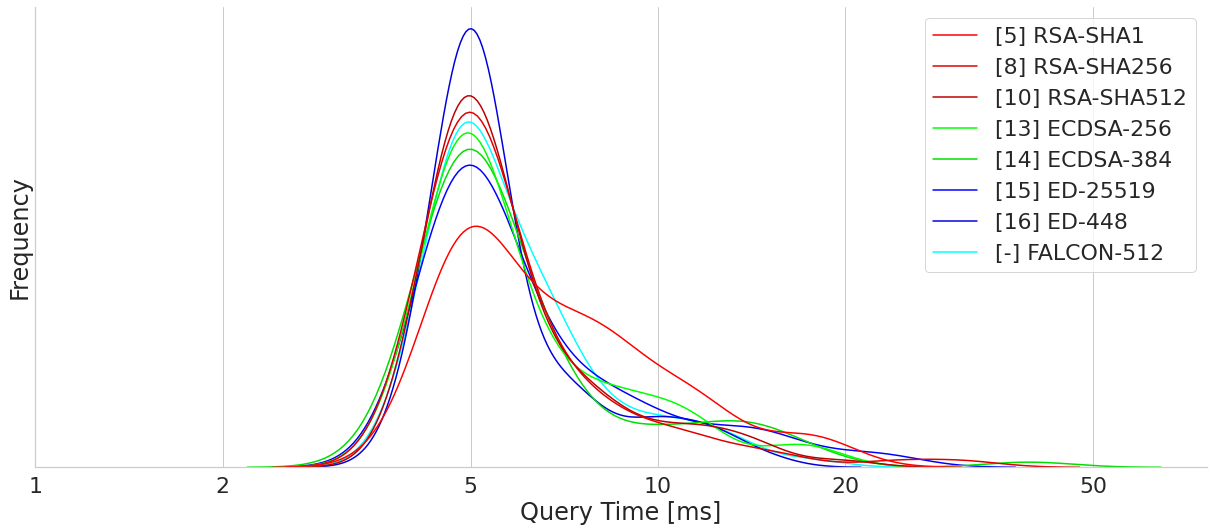

In [10]:
# visualize
g = sns.displot(
    query_times,
    x='query_time_ms', hue='algorithm', 
    hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    log_scale=(True, False),
    height=8,
    aspect=18/8,
    facet_kws=dict(legend_out=False),
    kind='kde',
)
g.set(
    #xlim=(1*1e-3, 1e-1), 
    xlabel='Query Time [ms]', 
    ylabel='Frequency', 
    yticks=[],
    xticks=[1,2,5,10,20,50],
    xticklabels=[1,2,5,10,20,50],
)
g.legend.set_title('')
g.savefig('data/query_times.pdf')

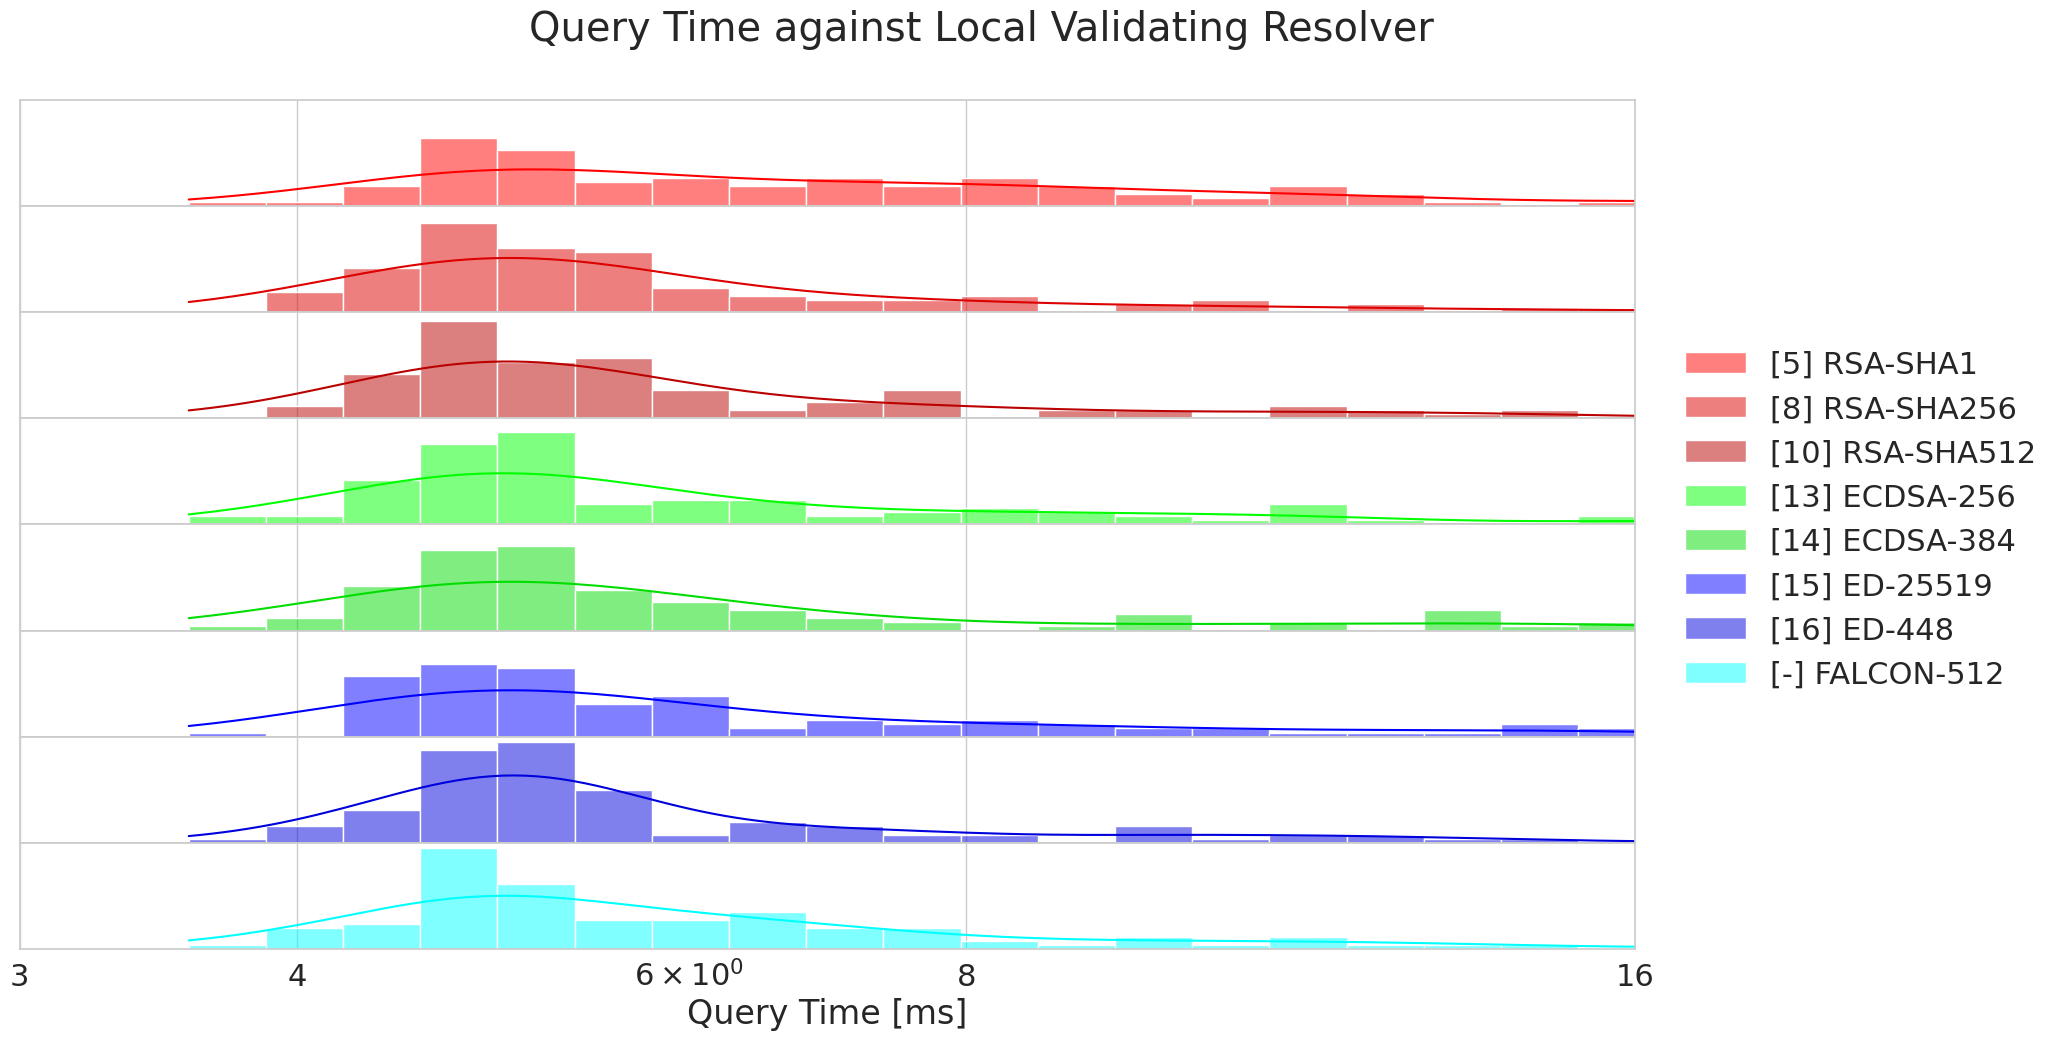

In [11]:
# visualize
g = sns.displot(
    query_times,
    x='query_time_ms', row='algorithm', hue='algorithm', 
    hue_order=ALGORITHM_ORDER, palette=ALGORITHM_PALETTE,
    log_scale=(True, False),
    height=1.3,
    aspect=18/1.3,
    facet_kws=dict(legend_out=True, margin_titles=False, despine=False),
    kind='hist',
    kde=True,
)
g.set(
    xlim=(3, 15), 
    xlabel='Query Time [ms]', 
    ylabel='', 
    yticks=[],
    xticks=[3,4,8,16],
    xticklabels=[3,4,8,16],
    title='',
)
g.figure.suptitle('Query Time against Local Validating Resolver', y=1.02)
g.figure.subplots_adjust(wspace=0, hspace=0)
g.legend.set_title('')
g.legend.set_zorder(1)
g.savefig('data/query_times_indv.pdf')